In [ ]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

from astropy.coordinates import SkyCoord, Angle, EarthLocation, get_sun
from astropy.io import ascii
from astropy.table import join, Table, vstack
from astropy.time import Time
import astropy.units as u

from astroquery.utils.tap.core import TapPlus

import timeit

In [ ]:
Table_A2 = ascii.read("Table_A2.txt")

In [ ]:
upper_mu = 18.8
lower_mu = 18.2
mu_select = Table_A2[
    (Table_A2["Distance_modulus"] >= lower_mu) & 
    (Table_A2["Distance_modulus"] <= upper_mu)
]

## Circular cut based on coordinates from catalogue

### A-1: From intact catalogue

In [ ]:
lmc_center = SkyCoord(ra=80.894167*u.degree, dec=-69.756111*u.degree, frame='icrs')
radius = 5* u.degree

data_coords = SkyCoord(ra=Table_A2["RA"]*u.degree, dec=Table_A2["DEC"]*u.degree, frame='icrs')

# Compute the separation angular separation from LMC
sep = data_coords.separation(lmc_center)
circular_data = Table_A2[sep < radius]

### A-2: From $\mu$-filtered catalogue

In [ ]:
data_coords = SkyCoord(ra=mu_select["RA"]*u.degree, dec=mu_select["DEC"]*u.degree, frame='icrs')

sep = data_coords.separation(lmc_center)

mu_cut_data = mu_select[sep<radius]

## Comparism: ML and coordinate cuts

In [ ]:
mu18_ra  = mu_select["RA"] 
mu18_dec = mu_select["DEC"]

# ML_ra =  mu18_ra[cluster_0]
# ML_dec = mu18_dec[cluster_0]

CircularCut_ra  = circular_data["RA"]
CircularCut_dec = circular_data["DEC"]

CircularMu_ra  = mu_cut_data["RA"]
CircularMu_dec = mu_cut_data["DEC"]

In [ ]:
plt.figure(figsize=(8, 6))
# plt.scatter(mu18_ra, mu18_dec, s=10, color='gray', marker='o', alpha=0.3, label="Sources")
# plt.scatter(ML_ra, ML_dec, s=10, color='red', marker='o', alpha=0.3, label="Sources")
plt.scatter(CircularCut_ra, CircularCut_dec, s=10, color='blue', marker='o', alpha=0.3, label="Sources")
plt.scatter(CircularMu_ra, CircularMu_dec, s=10, color='green', marker='o', alpha=0.3, label="Sources")
plt.grid(True)

In [ ]:
print("DBSCAN sample:", len(ML_ra))
print("Circular cut sample:", len(CircularCut_ra))
print("Circular cut + mu sample:", len(CircularMu_ra))

## Export Table

In [ ]:
mu_cut_data.write('Muraveva_LMC-gaia_ID.csv', format='csv', overwrite=True)

## Query SkyMapper DR4

In [ ]:
gaia_id = ascii.read("Muraveva_LMC-gaia_ID.csv")
SkyMapper = TapPlus(url="https://api.skymapper.nci.org.au/public/tap/")

### Query `object_id`

In [ ]:
test_list = gaia_id[0:1000]

print("Begin query SMSS object ID")

id_table = Table(names=["object_id", "gaia_dr3_id1", "raj2000", "dej2000"], dtype=["int64", "int64", "float64", "float64"])
start = timeit.default_timer()

for (gaia_id, ra, dec) in zip(test_list["source_id"], test_list["RA"], test_list["DEC"]):
    #print(f"Querying GAIA id: {gaia_id}")
    prompt = f"""
    SELECT
        object_id, gaia_dr3_id1, raj2000, dej2000
        FROM
            dr4.master 
        WHERE 
            1=CONTAINS(POINT('ICRS', raj2000, dej2000),
                       CIRCLE('ICRS', {ra}, {dec}, 0.1 ))
            AND gaia_dr3_id1={gaia_id}
    """
    
    job = SkyMapper.launch_job(prompt)
    result = job.get_data()

    if len(result) == 1:
        #print("SMSS ID:",result['object_id'][0])
        id_table = vstack([id_table, result])
    #else:
        #print("! No result qureied from GAIA ID")
    #print("=========================")

stop = timeit.default_timer()
print("Done SMSS object ID query")
print('Time: ', stop - start)
print('Total', len(id_table), "SMSS ID queried from GAIA DR3 object ID")

### Query `object_id` (w/ `multiprocessing`)

In [ ]:
# Select first 5000 entries for querying
test_list = gaia_id[0:1000]

# Initialize an empty table to store results
id_table = Table(names=["object_id", "gaia_dr3_id1", "raj2000", "dej2000"], 
                 dtype=["int64", "int64", "float64", "float64"])

def query_skymapper(gaia_id, ra, dec):
    prompt = f"""
    SELECT
        object_id, gaia_dr3_id1, raj2000, dej2000
    FROM
        dr4.master 
    WHERE 
        1=CONTAINS(POINT('ICRS', raj2000, dej2000),
                   CIRCLE('ICRS', {ra}, {dec}, 0.1 ))
        AND gaia_dr3_id1={gaia_id}
    """
    try:
        job = SkyMapper.launch_job(prompt)
        result = job.get_data()
        if len(result) == 1:
            return result
    except Exception as e:
        print(f"Query failed for GAIA ID {gaia_id}: {e}")
    return None

print("Begin query SMSS object ID")
start = timeit.default_timer()

num_workers = mp.cpu_count()  # Use all available CPU cores
with mp.Pool(processes=num_workers) as pool:
    results = pool.starmap(query_skymapper, zip(test_list["source_id"], test_list["RA"], test_list["DEC"]))

# Filter out None results and merge tables
valid_results = [r for r in results if r is not None]
if valid_results:
    id_table = vstack(valid_results)

stop = timeit.default_timer()
print("Done SMSS object ID query")
print('Time:', stop - start)
print('Total', len(id_table), "SMSS ID queried from GAIA DR3 object ID")

# Save results to CSV
id_table.write("SMSS_results.csv", format="csv", overwrite=True)
print("Results saved to 'SMSS_results.csv'")

### Query `image_id`

In [ ]:
smss_id = ascii.read("Muraveva_LMC-smss_ID.csv")
test_list = smss_id[0:100]

In [ ]:
image_id = Table(names=["object_id", "image_id", "ra_img", "decl_img", "filter", "mag_psf", "e_mag_psf", "date", "exp_time", "flags"], dtype=["int64", "int64", "float64", "float64", "str", "float32", "float32", "float64", "float32", "int16"])

print("Begin query SMSS photometry")
start = timeit.default_timer()

for ID in test_list['object_id']:
    prompt = f"""
    SELECT
        object_id, image_id, ra_img, decl_img, f.filter, mag_psf, e_mag_psf, date, exp_time, flags
        FROM
            dr4.photometry f
        JOIN
            dr4.images USING (image_id)
        WHERE
            object_id={ID}
            AND f.filter IN ('g', 'r', 'i')
    """
    job = SkyMapper.launch_job(prompt)
    result = job.get_results()
    
    image_id = vstack([image_id, result])

stop = timeit.default_timer()
print("Done SMSS query")
print('Query time:', stop - start)

image_id.write('Muraveva_LMC-smss_photometry.csv', format='csv', overwrite=True)

### Query `image_id` (w/ `multiprocessing`)

In [ ]:
image_id = Table(names=["object_id", "image_id", "ra_img", "decl_img", "filter", "mag_psf", "e_mag_psf", "date", "exp_time", "flags"], 
                 dtype=["int64", "int64", "float64", "float64", "str", "float32", "float32", "float64", "float32", "int16"])

def query_photometry(object_id):
    prompt = f"""
    SELECT
        object_id, image_id, ra_img, decl_img, f.filter, mag_psf, e_mag_psf, date, exp_time, flags
    FROM
        dr4.photometry f
    JOIN
        dr4.images USING (image_id)
    WHERE
        object_id={object_id}
        AND f.filter IN ('g', 'r', 'i')
    """
    try:
        job = SkyMapper.launch_job(prompt)
        result = job.get_results()
        if len(result) > 0:
            return result  # Return results only if there's data
    except Exception as e:
        print(f"Query failed for object_id {object_id}: {e}")
    return None  # Return None if the query fails

print("Begin query SMSS photometry")
start = timeit.default_timer()

num_workers = mp.cpu_count()  # Use all available CPU cores
with mp.Pool(processes=num_workers) as pool:
    results = pool.map(query_photometry, test_list['object_id'])

# Filter out None results and merge tables
valid_results = [r for r in results if r is not None]
if valid_results:
    image_id = vstack(valid_results)

stop = timeit.default_timer()
print("Done SMSS query")
print('Query time:', stop - start)
print(f'Total {len(image_id)} photometric entries retrieved.')

## Light-curve-template fitting

### modify and match id from the files

In [ ]:
import pandas as pd
import numpy as np
import apply_ugrizy_templates

# Load only required columns (if applicable) and limit rows for test cases
muraveva_df = pd.read_csv("Muraveva_LMC-gaia_ID.csv", usecols=["source_id", "RA", "DEC", "Type",
                                                               "Period", "[Fe/H]", "[Fe/H]_error", 
                                                               "E(B-V)", "E(B-V)_error", 
                                                               "Distance_modulus", "Distance_modulus_error"])
objid_df    = pd.read_csv("Muraveva_LMC-smss_ID.csv", usecols=["object_id", "gaia_dr3_id1"])
imageid_df  = pd.read_csv("Muraveva_LMC-smss_photometry.csv")

# Rename columns while reading (avoiding extra reassignment)
muraveva_df.rename(columns={'source_id': 'gaia_dr3_id1'}, inplace=True)

# Merge tables efficiently
merged_df = objid_df.merge(muraveva_df, on='gaia_dr3_id1', how="inner") \
                    .merge(imageid_df, on='object_id', how="inner")

### Using `apply_ugrizy_templates.py` (Braga+ 2024)

In [ ]:
def mag_filter(image_ls):
    return len(image_ls) > 3  # Returns True if good, False if bad

def mjd_to_hjd(mjd, ra, dec, observatory='greenwich'):
    """
    Convert MJD to Heliocentric Julian Date (HJD).
    
    Parameters:
    - mjd: float, Modified Julian Date
    - ra: float, Right Ascension in degrees
    - dec: float, Declination in degrees
    - observatory: str, Name of the observing location (default: Greenwich)
    
    Returns:
    - HJD: float, Heliocentric Julian Date
    """
    # Convert MJD to JD
    time = Time(mjd, format='mjd', scale='utc')
    
    # Define the observatory location (default Greenwich, override if needed)
    location = EarthLocation.of_site(observatory)
    
    # Define the celestial target coordinates
    target = SkyCoord(ra=ra * u.deg, dec=dec * u.deg)
    
    # Get the Sun's position
    light_time_correction = time.light_travel_time(target, 'heliocentric', location=location)
    
    # Apply correction to get HJD
    hjd = time.tdb + light_time_correction
    return hjd.jd

def type_band(rr_type, band):
    if rr_type == 'RRab':
        pulsation_type = 0
    else:
        pulsation_type = 1

    if band == 'g':
        passband = 2
    elif band == 'r':
        passband = 3
    elif band == 'i':
        passband = 4

    if pulsation_type == 0:
        amplmaxs = {2: 1.8, 3: 1.5, 4: 1.1, 5: 1.1}
        amplmins = {2: .2, 3: .15, 4: .1, 5: .1}
        amplratio_ogle_to_use = 'Ampl(x)/Ampl(I)_ab'
    else:
        amplmaxs = {2: .9, 3: .7, 4: .55, 5: 1.1}
        amplmins = {2: .1, 3: .05, 4: 0., 5: 0.}    
        amplratio_ogle_to_use = 'Ampl(x)/Ampl(I)_c'

    amplmax = amplmaxs[passband]
    amplmin = amplmins[passband]
        
    return pulsation_type, passband, amplmax, amplmin

def apply_light_curve_fit(data, file_coeff, t0=0):
    obj, pulsation_period, rr_type, ra, dec, band, feh, feh_err, EBV, EBV_err, mu, mu_err = data[['object_id', 'Period', 'Type', 'RA', 'DEC','filter',
                                                          "[Fe/H]", "[Fe/H]_error", "E(B-V)", "E(B-V)_error", 
                                                          "Distance_modulus", "Distance_modulus_error"]].iloc[0]
    pulsation_type, passband, ampl_max, ampl_min = type_band(rr_type, band)
    
    mag  = np.asarray(data['mag_psf'])
    err  = np.asarray(data['e_mag_psf'])
    date = np.asarray(data['date'])

    hjd = mjd_to_hjd(date, ra, dec)
    try:
        templatebin_int = apply_ugrizy_templates.find_templatebin(pulsation_type, 
                                                                  pulsation_period, 
                                                                  passband)[0]
    
        result_resample = apply_ugrizy_templates.apply_templatefit(hjd, mag, err,
                                                    pulsation_type, pulsation_period, t0, passband, 
                                                    file_coeff, ampl=(ampl_max+ampl_min)/2,
                                                    amplmax=ampl_max, amplmin=ampl_min, figure_out=f'{folder}/plot-lcfit/{obj}-{band}.pdf')
        return {
            "object_id": obj,
            "period": pulsation_period,
            "type": rr_type,
            "band": band,
            "mean_mag": result_resample['mag_mean'],
            "err_mag": result_resample['errmag_mean'],
            "chi_squared": result_resample['chisq'],
            "N_image": len(mag),
            "psf_mags": mag,
            "[Fe/H]": feh,
            "[Fe/H]_error": feh_err,
            "E(B-V)": EBV,
            "E(B-V)_error": EBV_err,
            "Distance_modulus": mu,
            "Distance_modulus_error": mu_err,
        }
        
    except Exception as e:
        return None

In [ ]:
objid = np.unique(merged_df['object_id'])[:100]

sample_dict = {f: {"good": [], "bad" : []} for f in ["g", "r", "i"]}

for obj in objid:
    current_target = merged_df[merged_df['object_id'] == obj]

    # Process all filters in one loop
    for band in ["g", "r", "i"]:
        image_data = current_target[current_target['filter'] == band]
        
        # Classify sample into good or bad
        category = "good" if mag_filter(image_data) else "bad"
        sample_dict[band][category].append(image_data)

In [ ]:
folder = os.getcwd()+'/' #To be changed by the user
file_coeff = folder+'templates_analytics_230901.csv'

In [ ]:
# Prepare the list of tasks
tasks = []
for band in ["g", "r", "i"]:
    tasks.extend([(data, file_coeff) for data in sample_dict[band]["good"]])
    
start = timeit.default_timer()

# Use multiprocessing to run tasks in parallel
if __name__ == "__main__":
    with mp.Pool(processes=mp.cpu_count()) as pool:  # Use all available CPU cores
        results_list = pool.starmap(apply_light_curve_fit, tasks)

    # Filter out None values (errors)
    results_list = [res for res in results_list if res is not None]

    # Convert results to a DataFrame and save to CSV
    df_results = pd.DataFrame(results_list)
    df_results.to_csv("light_curve_results.csv", index=False, float_format="%.6f")

    print("CSV export complete: light_curve_results.csv")

stop = timeit.default_timer()

print('Fitting time:', stop - start)

## Plot

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

mu_true = 18.477

data = pd.read_csv("light_curve_results.csv")

R = {"g": 3.518, "r": 2.617, "i": 1.971}

mg = data['band'] == 'g'
mr = data['band'] == 'r'
mi = data['band'] == 'i'

mab = data['type'] == 'RRab'
mc  = data['type'] == 'RRc'

logP = np.log10(data['period'])
FeH  = data['[Fe/H]'].values

data['mag_0'] = data['mean_mag'] - data['band'].map(R) * data['E(B-V)']
data['Mag'] = data['mag_0'] - data['Distance_modulus']

In [6]:
Ng22_PLZcoeffs = {
    'g': {'RR0':     {'a':  0.649, 'b': -0.302, 'c': 0.159}, 
          'RR1':     {'a':  0.411, 'b': -0.342, 'c': 0.092},
          'RR0+RR1': {'a':  0.801, 'b': -0.032, 'c': 0.190}},
    'r': {'RR0':     {'a':  0.337, 'b': -1.090, 'c': 0.139}, 
          'RR1':     {'a': -0.082, 'b': -1.393, 'c': 0.091},
          'RR0+RR1': {'a':  0.432, 'b': -0.874, 'c': 0.154}},
    'i': {'RR0':     {'a':  0.243, 'b': -1.432, 'c': 0.144}, 
          'RR1':     {'a': -0.205, 'b': -1.706, 'c': 0.077},
          'RR0+RR1': {'a':  0.249, 'b': -1.362, 'c': 0.115}}
}

Na24_PLcoeffs01 = { # Parallax
    'g': {'RR0':     {'a':  -2.242, 'b': 0.805, 'c': 0}, 
          'RR1':     {'a':  -1.984, 'b': 0.605, 'c': 0},
          'RR0+RR1': {'a':  -1.500, 'b': 0.773, 'c': 0}},
    'r': {'RR0':     {'a':  -2.528, 'b': 0.660, 'c': 0}, 
          'RR1':     {'a':  -2.266, 'b': 0.557, 'c': 0},
          'RR0+RR1': {'a':  -1.929, 'b': 0.634, 'c': 0}},
    'i': {'RR0':     {'a':  -2.799, 'b': 0.642, 'c': 0}, 
          'RR1':     {'a':  -2.393, 'b': 0.598, 'c': 0},
          'RR0+RR1': {'a':  -2.249, 'b': 0.619, 'c': 0}}
}

Na24_PLcoeffs02 = { # ABL
    'g': {'RR0':     {'a':  -2.318, 'b': 0.810, 'c': 0}, 
          'RR1':     {'a':  -1.862, 'b': 0.615, 'c': 0},
          'RR0+RR1': {'a':  -1.506, 'b': 0.783, 'c': 0}},
    'r': {'RR0':     {'a':  -2.594, 'b': 0.663, 'c': 0}, 
          'RR1':     {'a':  -2.143, 'b': 0.566, 'c': 0},
          'RR0+RR1': {'a':  -1.918, 'b': 0.641, 'c': 0}},
    'i': {'RR0':     {'a':  -2.870, 'b': 0.644, 'c': 0}, 
          'RR1':     {'a':  -2.280, 'b': 0.606, 'c': 0},
          'RR0+RR1': {'a':  -2.230, 'b': 0.626, 'c': 0}}
}
Na24_PLcoeffs03 = { # Geometric Distance
    'g': {'RR0':     {'a':  -2.162, 'b': 0.802, 'c': 0}, 
          'RR1':     {'a':  -1.983, 'b': 0.604, 'c': 0},
          'RR0+RR1': {'a':  -1.448, 'b': 0.771, 'c': 0}},
    'r': {'RR0':     {'a':  -2.447, 'b': 0.657, 'c': 0}, 
          'RR1':     {'a':  -2.266, 'b': 0.556, 'c': 0},
          'RR0+RR1': {'a':  -1.878, 'b': 0.633, 'c': 0}},
    'i': {'RR0':     {'a':  -2.718, 'b': 0.639, 'c': 0}, 
          'RR1':     {'a':  -2.392, 'b': 0.597, 'c': 0},
          'RR0+RR1': {'a':  -2.197, 'b': 0.618, 'c': 0}}
}
Na24_PLcoeffs04 = { # Photo-geometric distance
    'g': {'RR0':     {'a':  -2.179, 'b': 0.803, 'c': 0}, 
          'RR1':     {'a':  -2.035, 'b': 0.607, 'c': 0},
          'RR0+RR1': {'a':  -1.462, 'b': 0.771, 'c': 0}},
    'r': {'RR0':     {'a':  -2.465, 'b': 0.658, 'c': 0}, 
          'RR1':     {'a':  -2.317, 'b': 0.558, 'c': 0},
          'RR0+RR1': {'a':  -1.891, 'b': 0.633, 'c': 0}},
    'i': {'RR0':     {'a':  -2.736, 'b': 0.640, 'c': 0}, 
          'RR1':     {'a':  -2.444, 'b': 0.599, 'c': 0},
          'RR0+RR1': {'a':  -2.211, 'b': 0.618, 'c': 0}}
}

Na24_PLZcoeffs01 = { # Parallax
    'g': {'RR0':     {'a':  -0.527, 'b': 0.794, 'c': 0.264}, 
          'RR0+RR1': {'a':  -0.284, 'b': 0.791, 'c': 0.289}},
    'r': {'RR0':     {'a':  -1.230, 'b': 0.651, 'c': 0.205}, 
          'RR0+RR1': {'a':  -1.017, 'b': 0.650, 'c': 0.228}},
    'i': {'RR0':     {'a':  -1.682, 'b': 0.635, 'c': 0.174}, 
          'RR0+RR1': {'a':  -1.469, 'b': 0.633, 'c': 0.198}}
}

Na24_PLZcoeffs02 = { # ABL
    'g': {'RR0':     {'a':  -0.503, 'b': 0.798, 'c': 0.266}, 
          'RR0+RR1': {'a':  -0.290, 'b': 0.795, 'c': 0.290}},
    'r': {'RR0':     {'a':  -1.227, 'b': 0.655, 'c': 0.204}, 
          'RR0+RR1': {'a':  -1.031, 'b': 0.652, 'c': 0.227}},
    'i': {'RR0':     {'a':  -1.673, 'b': 0.638, 'c': 0.175}, 
          'RR0+RR1': {'a':  -1.479, 'b': 0.635, 'c': 0.197}}
}

Na24_PLZcoeffs03 = { # Geometric Distance
    'g': {'RR0':     {'a':  -0.389, 'b': 0.792, 'c': 0.267}, 
          'RR0+RR1': {'a':  -0.217, 'b': 0.790, 'c': 0.285}},
    'r': {'RR0':     {'a':  -1.092, 'b': 0.650, 'c': 0.208}, 
          'RR0+RR1': {'a':  -0.950, 'b': 0.648, 'c': 0.223}},
    'i': {'RR0':     {'a':  -1.544, 'b': 0.633, 'c': 0.177}, 
          'RR0+RR1': {'a':  -1.402, 'b': 0.632, 'c': 0.193}}
}

Na24_PLZcoeffs04 = { # Geometric Distance
    'g': {'RR0':     {'a':  -0.473, 'b': 0.791, 'c': 0.257}, 
          'RR0+RR1': {'a':  -0.260, 'b': 0.789, 'c': 0.280}},
    'r': {'RR0':     {'a':  -1.177, 'b': 0.650, 'c': 0.198}, 
          'RR0+RR1': {'a':  -0.993, 'b': 0.647, 'c': 0.218}},
    'i': {'RR0':     {'a':  -1.629, 'b': 0.633, 'c': 0.168}, 
          'RR0+RR1': {'a':  -1.445, 'b': 0.631, 'c': 0.188}}
}

P0_pivot = {'RR0':     -0.25,
            'RR1':     -0.45,
            'RR0+RR1': -0.25}

He25_PLZcoeffs = {
    'g': {'RR0': {'a':  -0.829, 'b': 0.233, 'c': 0.976}, 
          'RR1': {'a':  -0.898, 'b': 0.148, 'c': 0.509}},
    'r': {'RR0': {'a':  -1.432, 'b': 0.180, 'c': 0.561}, 
          'RR1': {'a':  -1.395, 'b': 0.139, 'c': 0.202}},
    'i': {'RR0': {'a':  -1.639, 'b': 0.169, 'c': 0.442}, 
          'RR1': {'a':  -1.551, 'b': 0.135, 'c': 0.120}}
}

In [7]:
mag_masks = {
    "RR0": {
        "g": mab & mg,
        "r": mab & mr,
        "i": mab & mi
    },
    "RR1": {
        "g": mc & mg,
        "r": mc & mr,
        "i": mc & mi
    },
    "RR0+RR1": {
        "g": [mab & mg, mc & mg] ,
        "r": [mab & mr, mc & mr],
        "i": [mab & mi, mc & mi]
    }
}

In [8]:
def PLZrelation(logp, feh, passband, rrtype, coeffs, model):
    a, b, c = coeffs[passband][rrtype].values()
    
    if rrtype == 'RR0+RR1':
        type0, type1 = mag_masks[rrtype][passband]
        mask = np.logical_or(type0, type1)
        p0 = logp[type0].values
        p1 = logp[type1].values + 0.127
        p = np.concatenate((p0, p1), axis=0)
    else:
        mask = mag_masks[rrtype][passband]
        p = logp[mask]

    if model == 'Ng22':
        a, b, c = coeffs[passband][rrtype].values()
        return a + b * p + c * feh[mask]
    elif model == 'Na24':
        P0 = P0_pivot[rrtype]
        feh0 = -1.5
        return a * (logp[mask] - P0) + b + c * (feh[mask] - feh0)
    elif model == 'He25':
        a, b, c = coeffs[passband][rrtype].values()
        return a * p + b * feh[mask] + c

def plot_PLZhist(passband, rrtype, coeffs, model, mu_true, bins_factor=10):
    if rrtype == 'RR0+RR1':
        type0, type1 = mag_masks[rrtype][passband]
        m0 = data['mag_0'][type0].values
        m1 = data['mag_0'][type1].values
        m = np.concatenate((m0, m1), axis=0)
    else:
        mask = mag_masks[rrtype][passband]
        m = data['mag_0'][mask].values
        
    M = PLZrelation(logP, FeH, passband, rrtype, coeffs, model)
    
    delta_mu = (m - M) - mu_true

    dmean   = np.mean(delta_mu)
    dmedian = np.median(delta_mu)
    N = len(m)
    
    print(f"Mean: {dmean:.3f}, Median: {dmedian:.3f}")
    plt.figure(figsize=(7, 5))
    plt.minorticks_on()
    plt.tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='inout')
    plt.hist(delta_mu, bins=int(N / bins_factor) + 8, color='skyblue', edgecolor='black')
    plt.axvline(0.0, c='r', ls='-')  # True distance modulus
    plt.axvline(dmean, c='r', ls='--', label=f"Mean = {dmean:.3f}")
    plt.ylabel("Count", fontsize=13)
    plt.xlabel(r"$\mu_j-\mu_{LMC}^0$", fontsize=13)
    plt.title(f"Counts of Distance Modulus Residuals ({passband}-band, {rrtype})", fontsize=14)
    plt.tight_layout()
    plt.legend()
    plt.show()

### PLZ for RR0, RR1, and RR0+RR1

#### RR0

Mean: 0.080, Median: 0.137


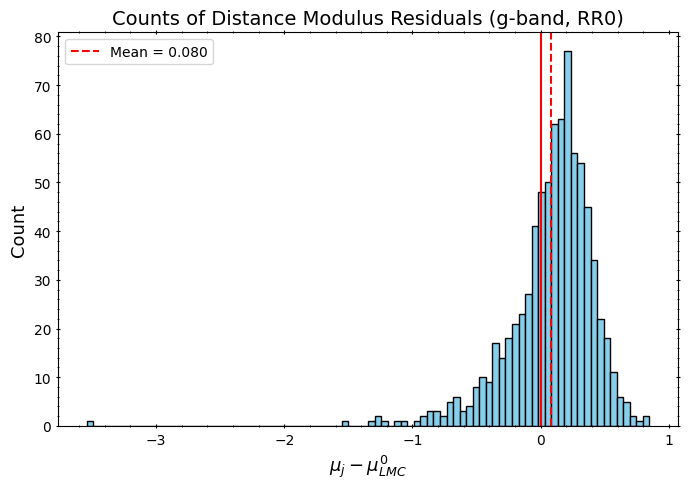

Mean: -0.247, Median: -0.189


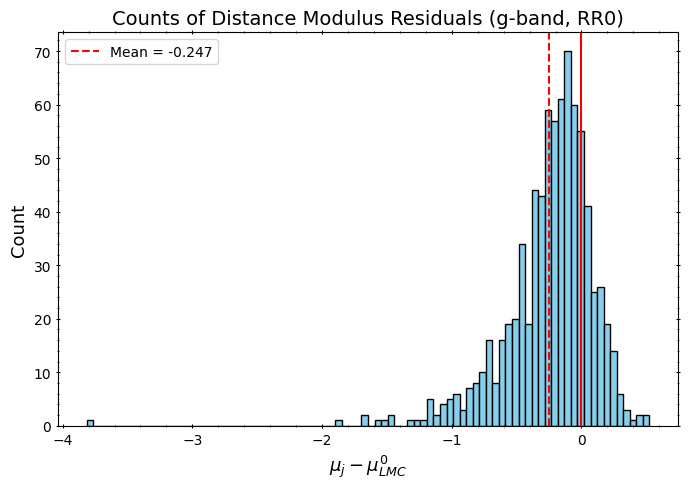

Mean: -0.207, Median: -0.148


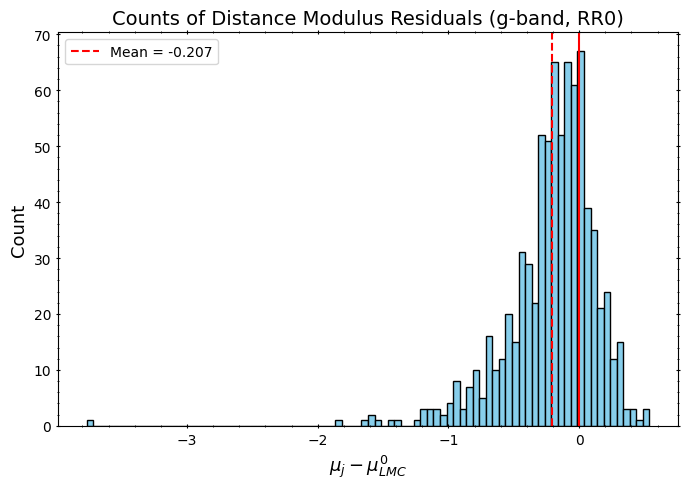

Mean: -0.211, Median: -0.153


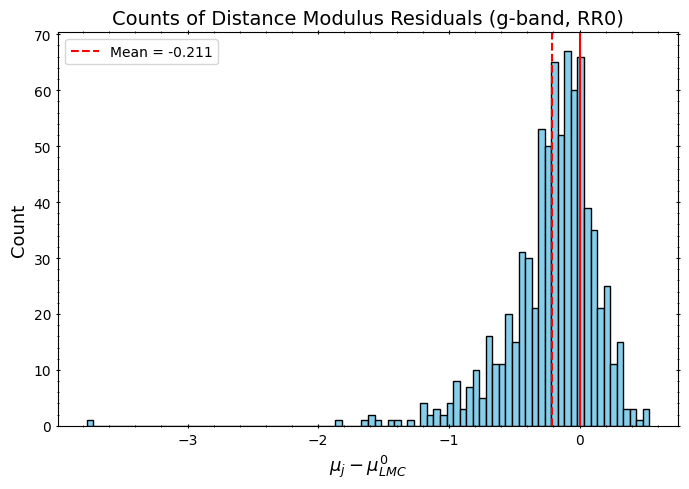

Mean: -0.207, Median: -0.151


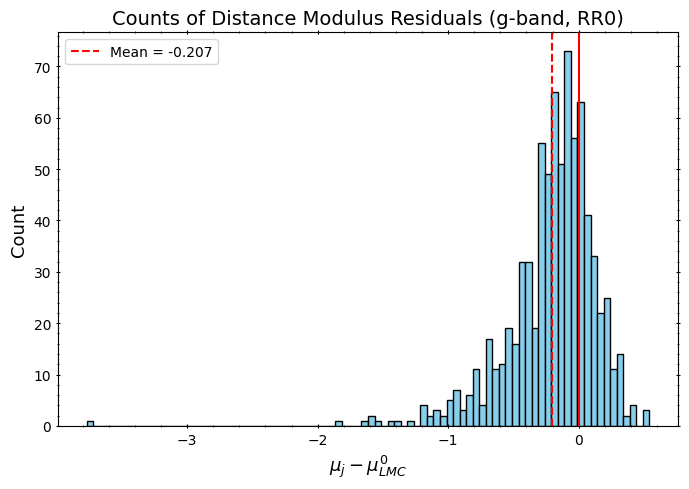

Mean: -0.206, Median: -0.148


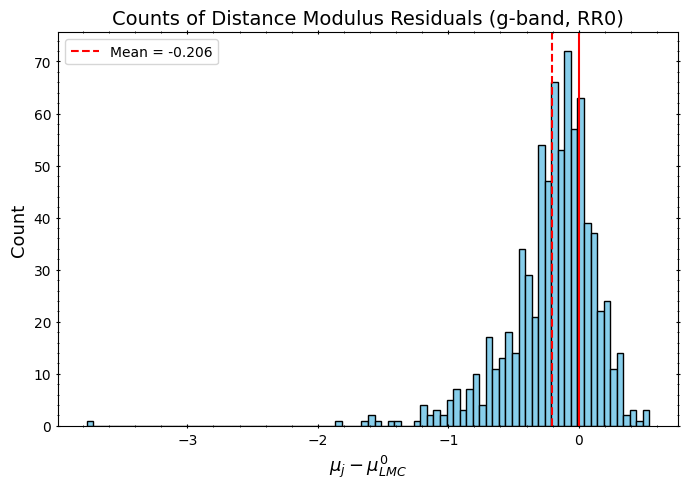

In [9]:
plot_PLZhist("g", "RR0", Ng22_PLZcoeffs, 'Ng22', mu_true)
plot_PLZhist("g", "RR0", He25_PLZcoeffs, 'He25', mu_true)
plot_PLZhist("g", "RR0", Na24_PLZcoeffs01, 'Na24', mu_true)
plot_PLZhist("g", "RR0", Na24_PLZcoeffs02, 'Na24', mu_true)
plot_PLZhist("g", "RR0", Na24_PLZcoeffs03, 'Na24', mu_true)
plot_PLZhist("g", "RR0", Na24_PLZcoeffs04, 'Na24', mu_true)

Mean: 0.033, Median: 0.116


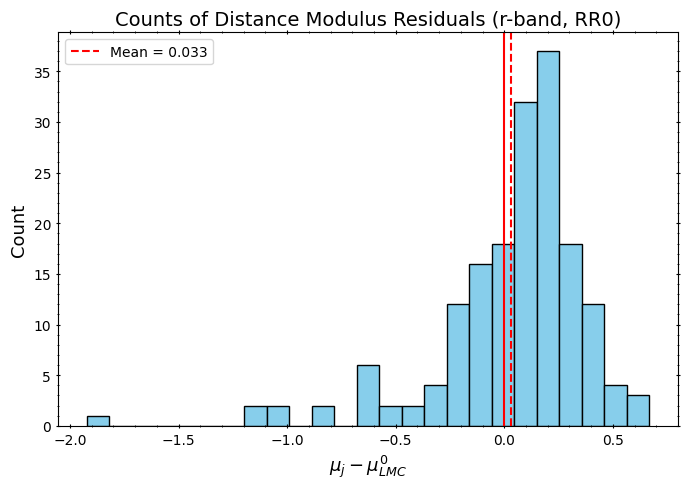

Mean: -0.205, Median: -0.138


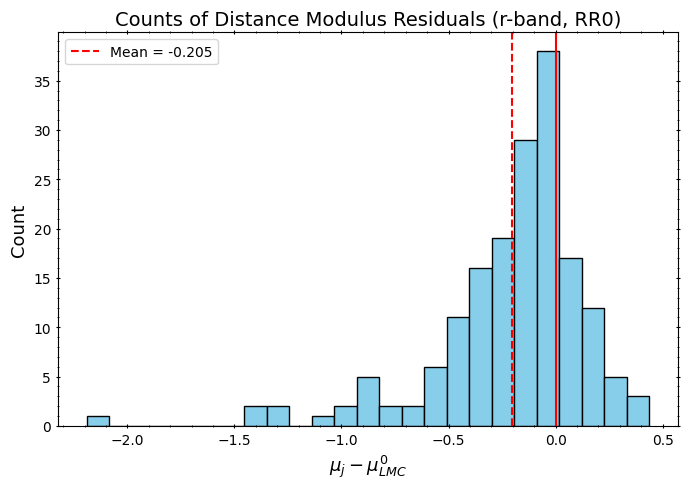

Mean: -0.207, Median: -0.131


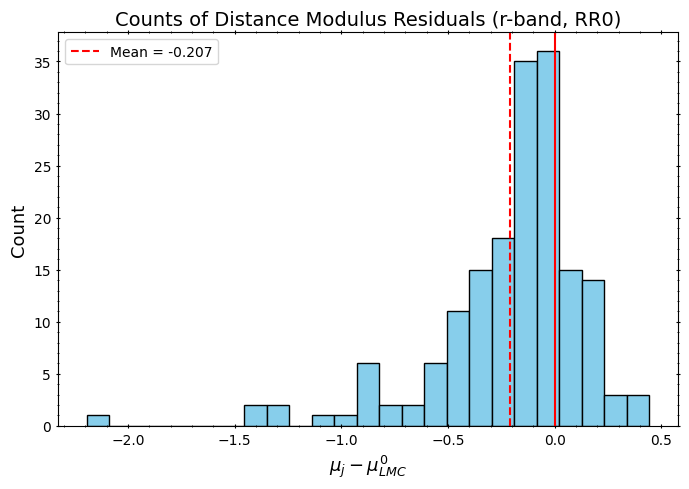

Mean: -0.211, Median: -0.135


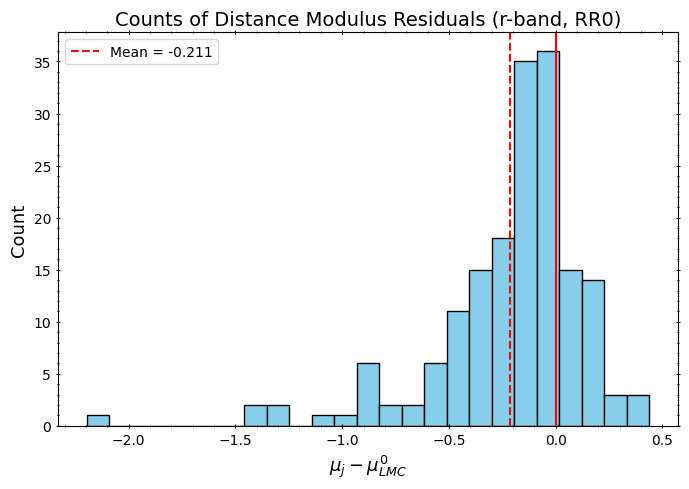

Mean: -0.208, Median: -0.131


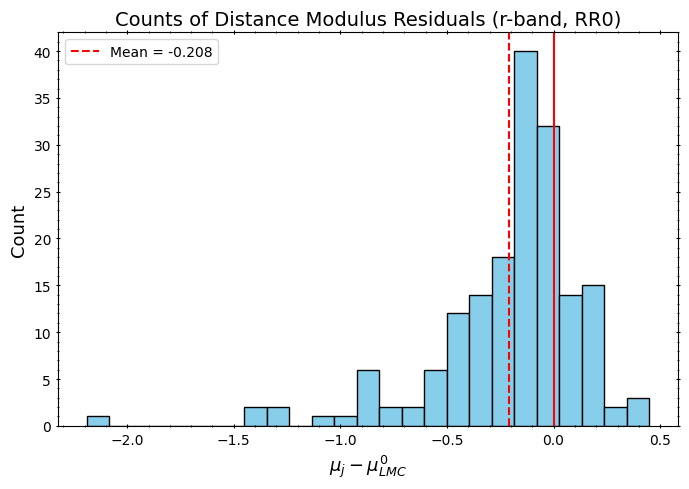

Mean: -0.208, Median: -0.131


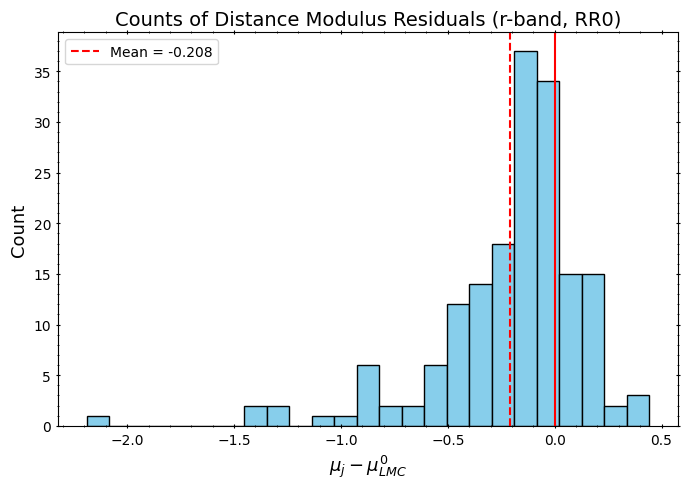

In [10]:
plot_PLZhist("r", "RR0", Ng22_PLZcoeffs, 'Ng22', mu_true)
plot_PLZhist("r", "RR0", He25_PLZcoeffs, 'He25', mu_true)
plot_PLZhist("r", "RR0", Na24_PLZcoeffs01, 'Na24', mu_true)
plot_PLZhist("r", "RR0", Na24_PLZcoeffs02, 'Na24', mu_true)
plot_PLZhist("r", "RR0", Na24_PLZcoeffs03, 'Na24', mu_true)
plot_PLZhist("r", "RR0", Na24_PLZcoeffs04, 'Na24', mu_true)

Mean: -0.056, Median: 0.035


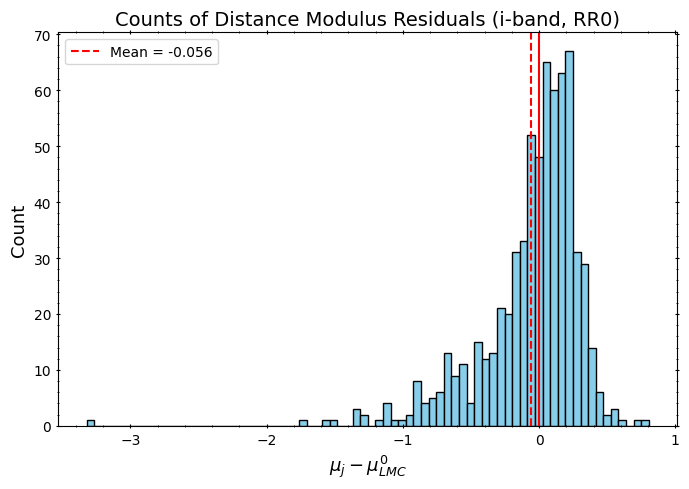

Mean: -0.259, Median: -0.167


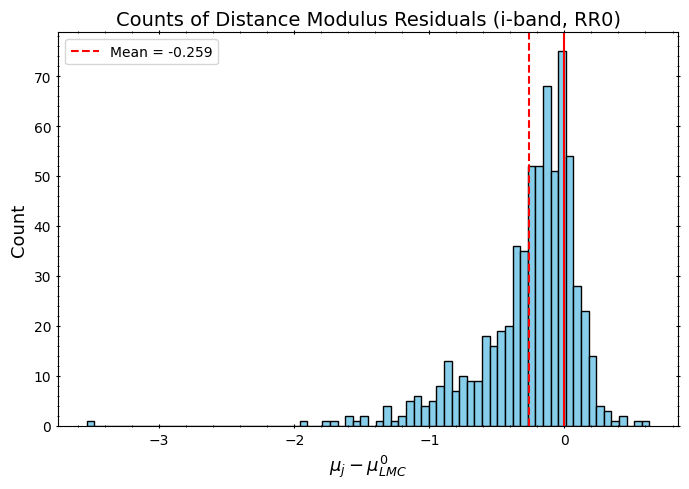

Mean: -0.294, Median: -0.203


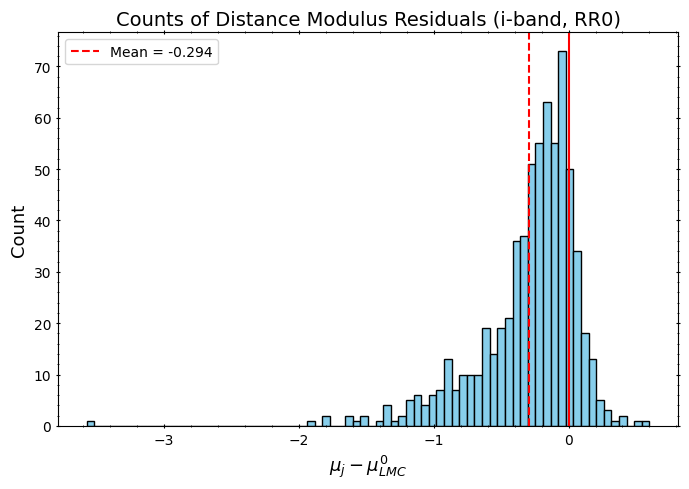

Mean: -0.297, Median: -0.206


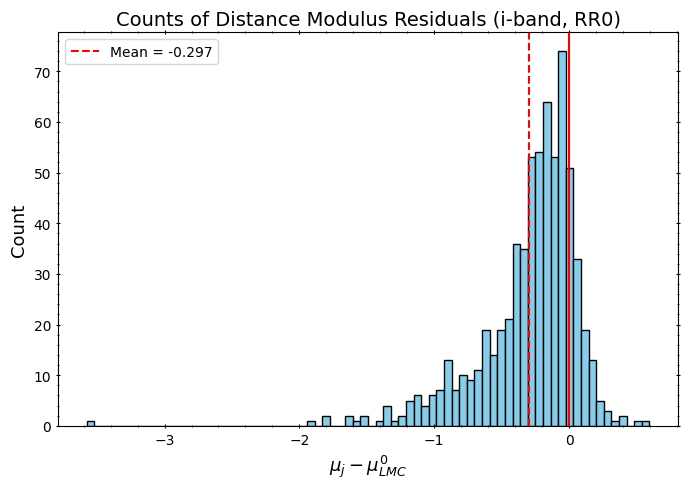

Mean: -0.295, Median: -0.205


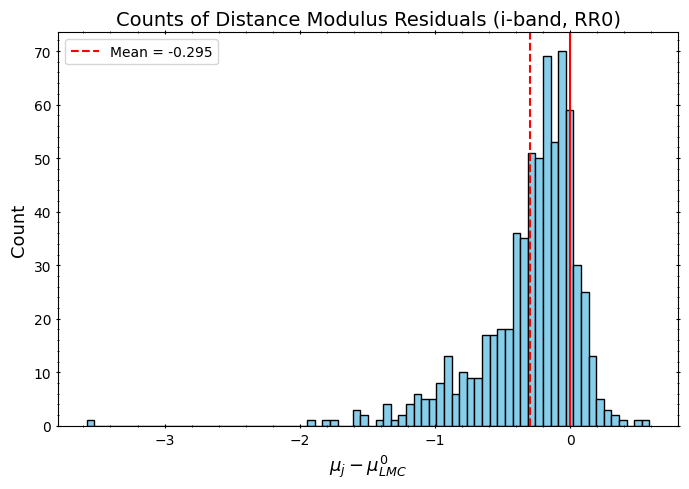

Mean: -0.294, Median: -0.202


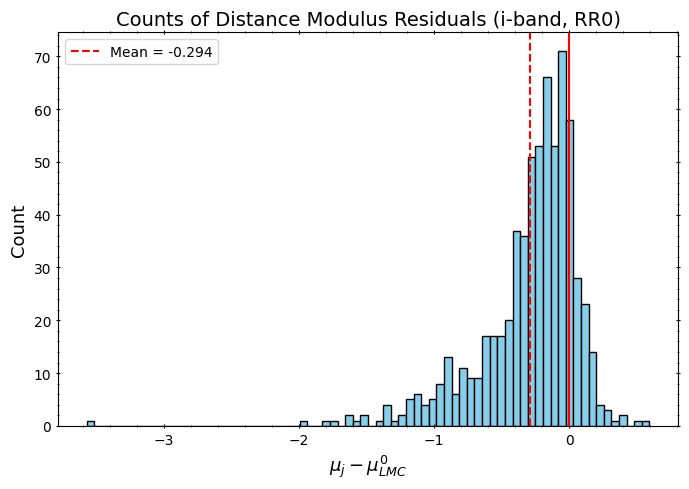

In [11]:
plot_PLZhist("i", "RR0", Ng22_PLZcoeffs, 'Ng22', mu_true)
plot_PLZhist("i", "RR0", He25_PLZcoeffs, 'He25', mu_true)
plot_PLZhist("i", "RR0", Na24_PLZcoeffs01, 'Na24', mu_true)
plot_PLZhist("i", "RR0", Na24_PLZcoeffs02, 'Na24', mu_true)
plot_PLZhist("i", "RR0", Na24_PLZcoeffs03, 'Na24', mu_true)
plot_PLZhist("i", "RR0", Na24_PLZcoeffs04, 'Na24', mu_true)

#### RR1

Mean: 0.060, Median: 0.079


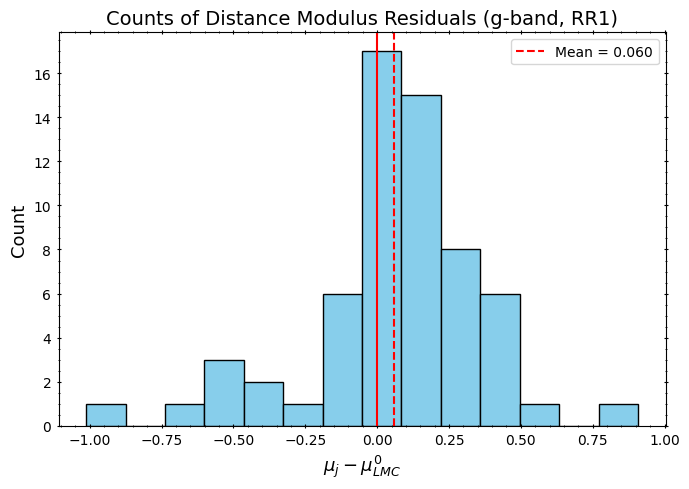

Mean: -0.208, Median: -0.182


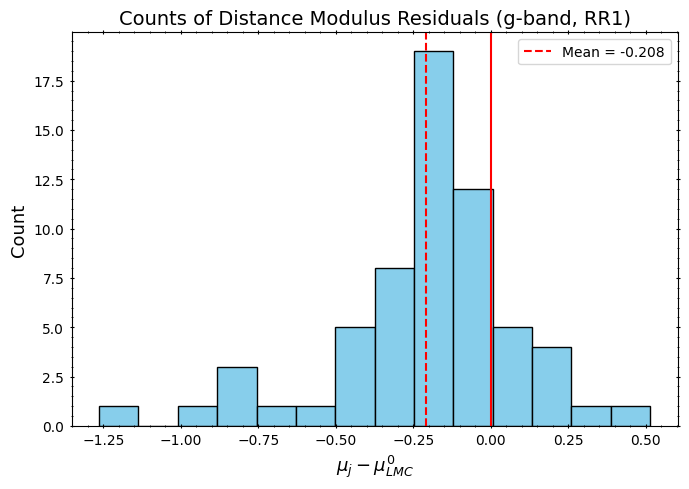

In [12]:
plot_PLZhist("g", "RR1", Ng22_PLZcoeffs, 'Ng22', mu_true)
plot_PLZhist("g", "RR1", He25_PLZcoeffs, 'He25', mu_true)

Mean: -0.199, Median: -0.050


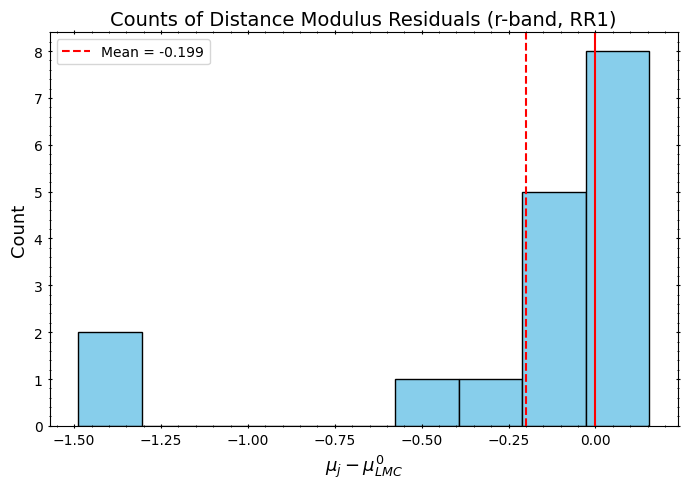

Mean: -0.400, Median: -0.252


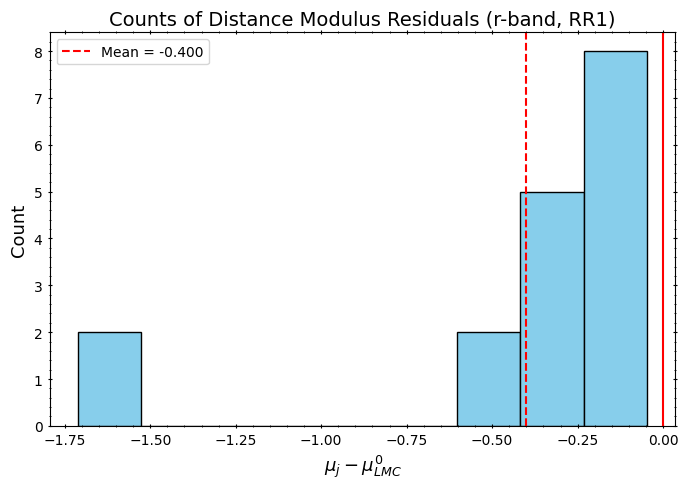

In [13]:
plot_PLZhist("r", "RR1", Ng22_PLZcoeffs, 'Ng22', mu_true)
plot_PLZhist("r", "RR1", He25_PLZcoeffs, 'He25', mu_true)

Mean: -0.023, Median: 0.067


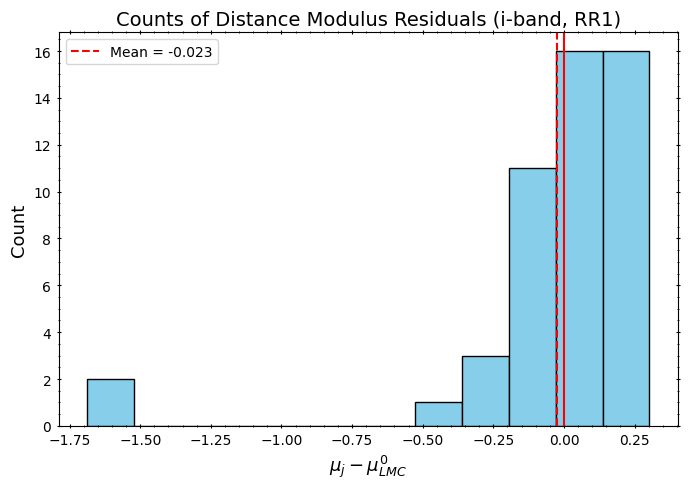

Mean: -0.172, Median: -0.069


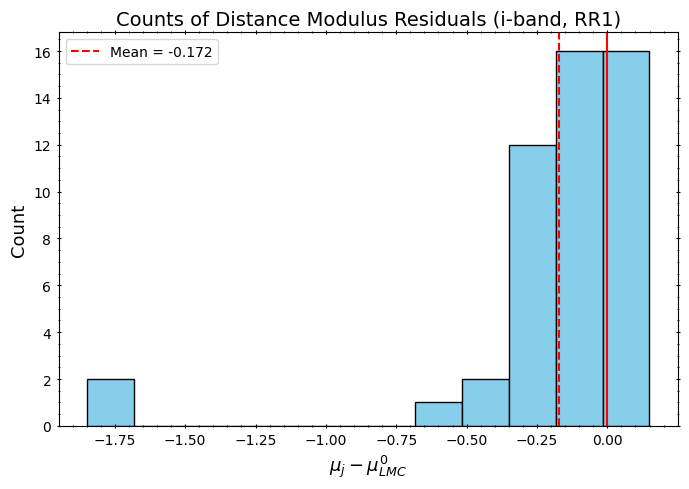

In [14]:
plot_PLZhist("i", "RR1", Ng22_PLZcoeffs, 'Ng22', mu_true)
plot_PLZhist("i", "RR1", He25_PLZcoeffs, 'He25', mu_true)

#### RR0+RR1

Mean: 0.038, Median: 0.078


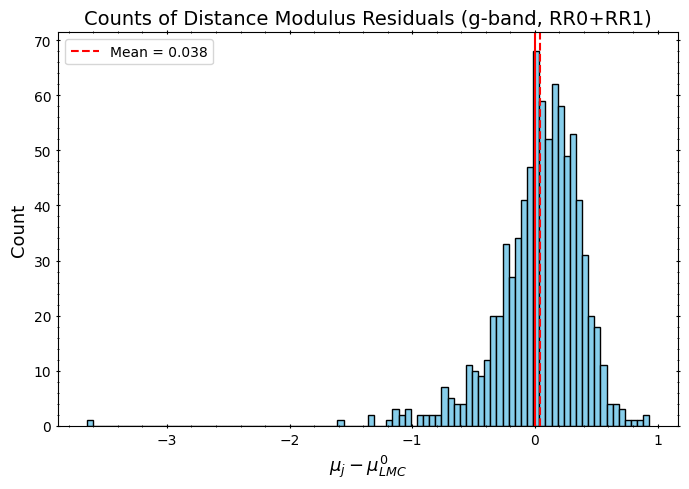

Mean: -0.213, Median: -0.177


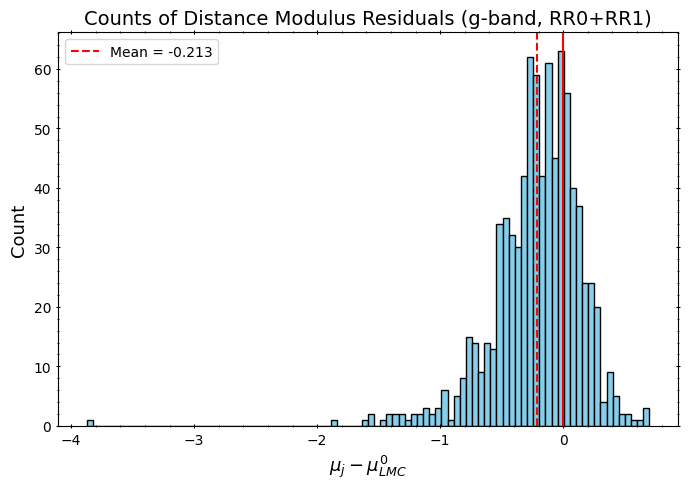

Mean: -0.216, Median: -0.182


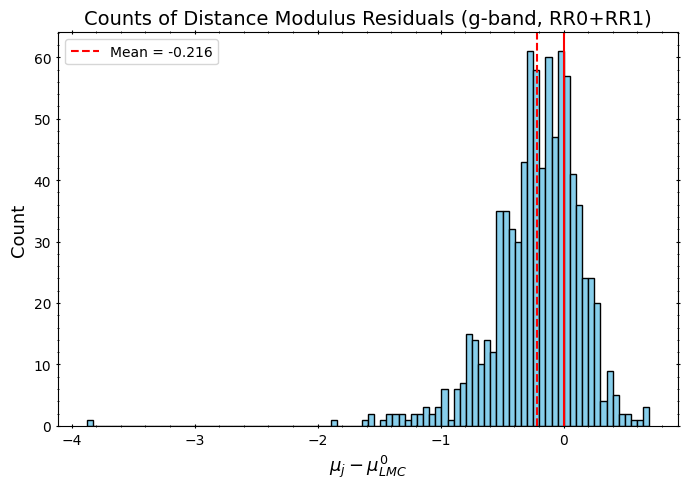

Mean: -0.212, Median: -0.175


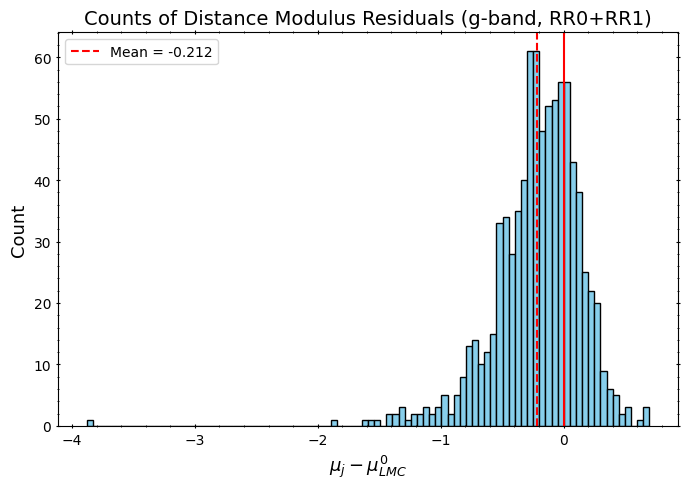

Mean: -0.212, Median: -0.176


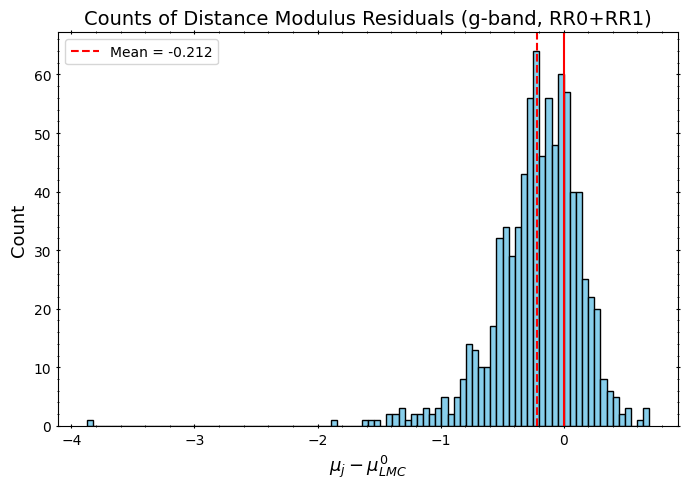

In [15]:
plot_PLZhist("g", "RR0+RR1", Ng22_PLZcoeffs, 'Ng22', mu_true)
plot_PLZhist("g", "RR0+RR1", Na24_PLZcoeffs01, 'Na24', mu_true)
plot_PLZhist("g", "RR0+RR1", Na24_PLZcoeffs02, 'Na24', mu_true)
plot_PLZhist("g", "RR0+RR1", Na24_PLZcoeffs03, 'Na24', mu_true)
plot_PLZhist("g", "RR0+RR1", Na24_PLZcoeffs04, 'Na24', mu_true)

Mean: -0.010, Median: 0.054


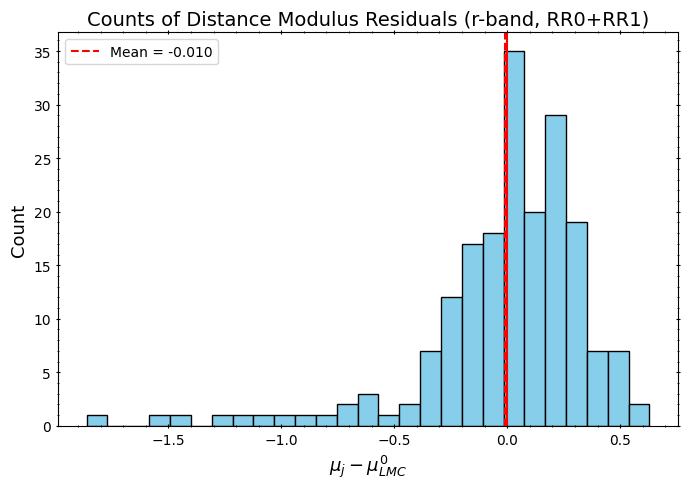

Mean: -0.242, Median: -0.150


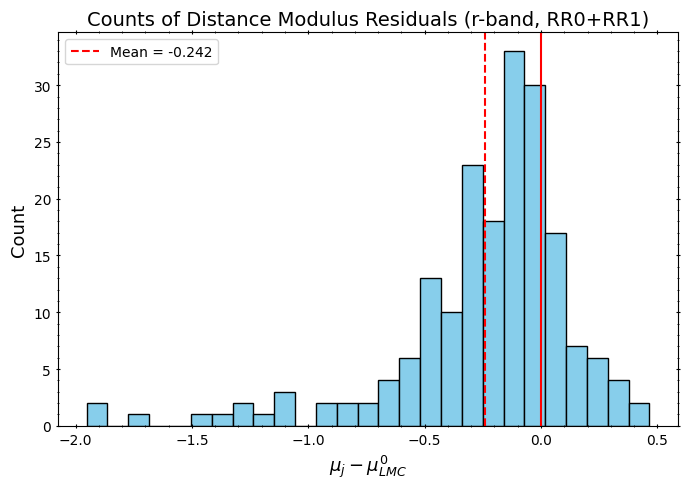

Mean: -0.244, Median: -0.153


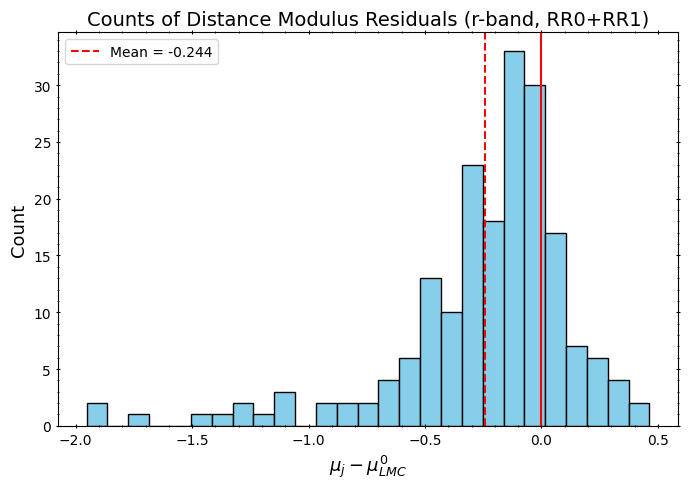

Mean: -0.240, Median: -0.150


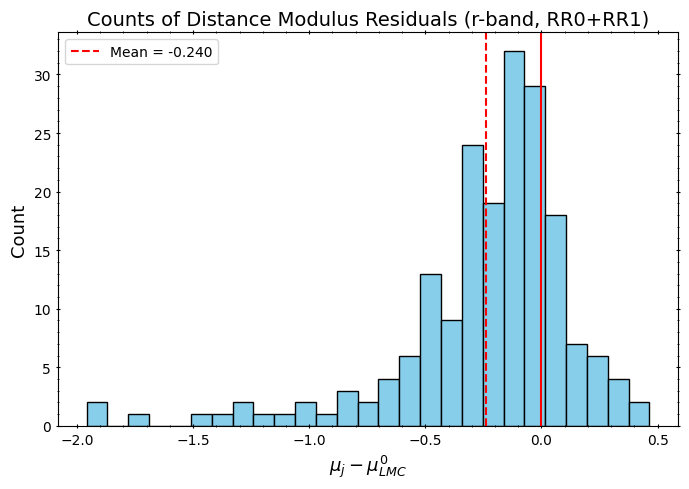

Mean: -0.240, Median: -0.149


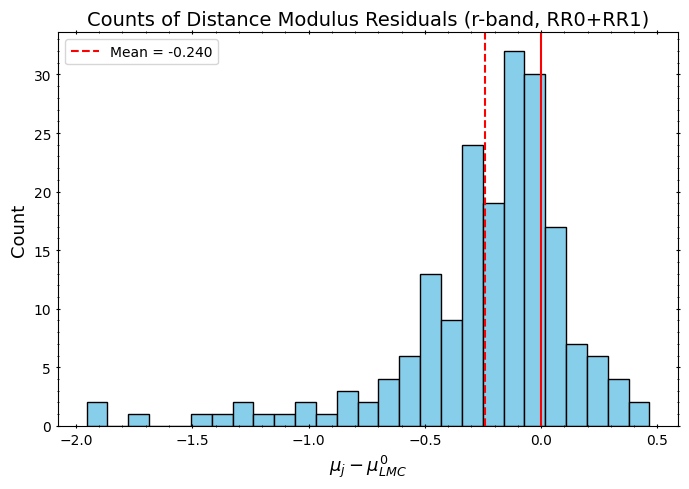

In [16]:
plot_PLZhist("r", "RR0+RR1", Ng22_PLZcoeffs, 'Ng22', mu_true)
plot_PLZhist("r", "RR0+RR1", Na24_PLZcoeffs01, 'Na24', mu_true)
plot_PLZhist("r", "RR0+RR1", Na24_PLZcoeffs02, 'Na24', mu_true)
plot_PLZhist("r", "RR0+RR1", Na24_PLZcoeffs03, 'Na24', mu_true)
plot_PLZhist("r", "RR0+RR1", Na24_PLZcoeffs04, 'Na24', mu_true)

Mean: -0.094, Median: -0.019


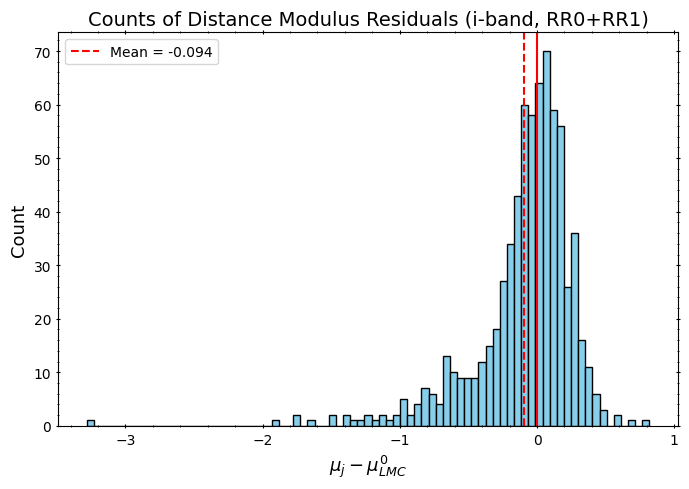

Mean: -0.304, Median: -0.238


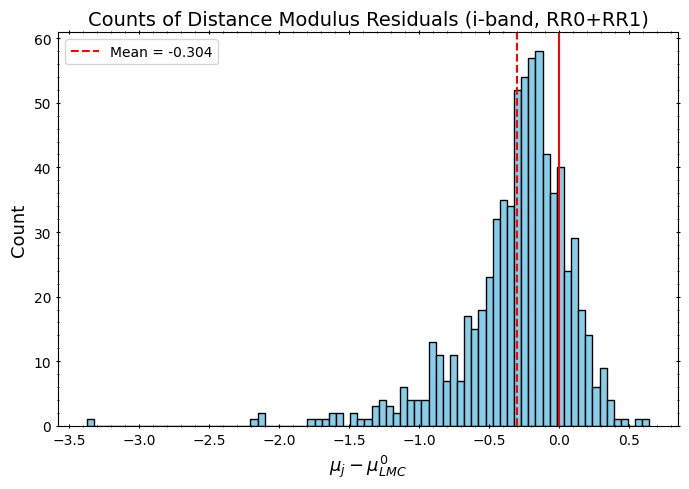

Mean: -0.307, Median: -0.239


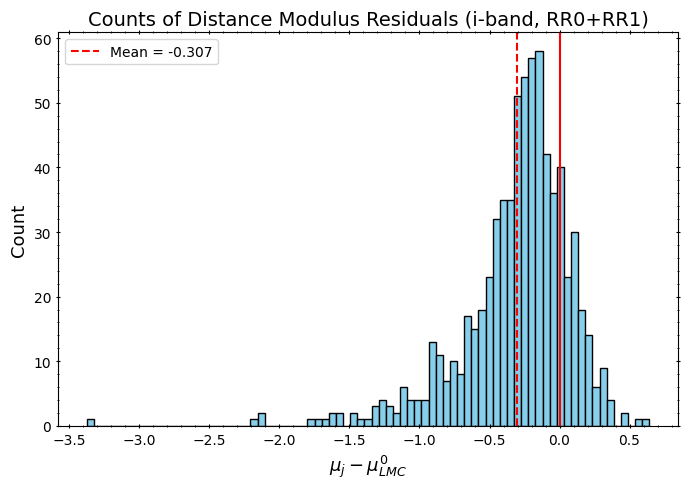

Mean: -0.305, Median: -0.238


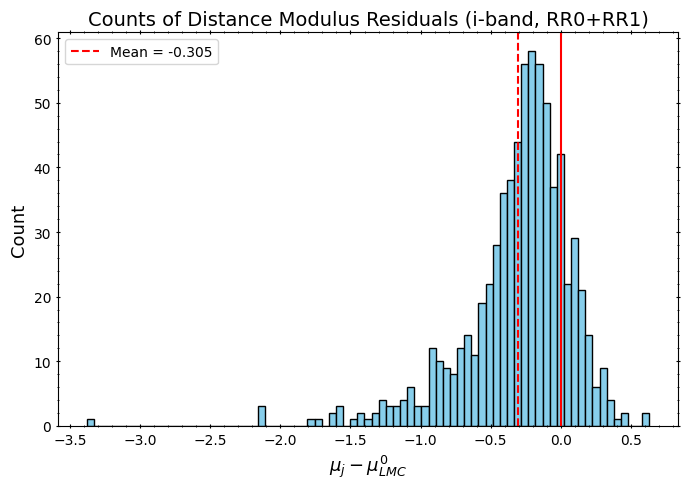

Mean: -0.305, Median: -0.238


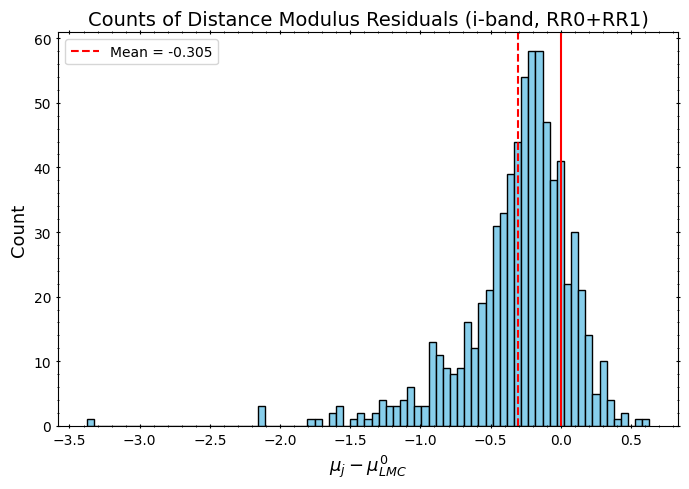

In [17]:
plot_PLZhist("i", "RR0+RR1", Ng22_PLZcoeffs, 'Ng22', mu_true)
plot_PLZhist("i", "RR0+RR1", Na24_PLZcoeffs01, 'Na24', mu_true)
plot_PLZhist("i", "RR0+RR1", Na24_PLZcoeffs02, 'Na24', mu_true)
plot_PLZhist("i", "RR0+RR1", Na24_PLZcoeffs03, 'Na24', mu_true)
plot_PLZhist("i", "RR0+RR1", Na24_PLZcoeffs04, 'Na24', mu_true)

### PWZ for RR0, RR0+RR1

#### RR0

#### RR1

#### RR0+RR1